<a href="https://colab.research.google.com/github/dailykim149656-source/Material_ML_Project/blob/main/material_ml_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 셀 1: 라이브러리 설치 및 불러오기
!pip install pandas numpy scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import re

In [2]:
# 셀 2: 데이터 불러오기
data_material = pd.read_csv('/content/ceramic_data_20200917/한국세라믹기술원_세라믹소재정보은행 소재 정보_20200917.csv',
                            encoding='cp949', low_memory=False)
data_property = pd.read_csv('/content/ceramic_data_20200917/한국세라믹기술원_세라믹소재정보은행 물성 정보_20200917.csv',
                            encoding='cp949', low_memory=False)
data_detail = pd.read_csv('/content/ceramic_data_20200917/한국세라믹기술원_세라믹소재정보은행 변화물성 정보_20200917.csv',
                          encoding='cp949', low_memory=False)

In [3]:
# 셀 5: sintering density인 물성시퀀스 추출
target_seq = data_detail[
    data_detail['측정변수명'].str.lower()=='sintering density'
]['물성시퀀스'].unique()

In [4]:
# 셀 6: 소재정보에서 해당 소재만 필터
filtered_material = data_material[
    data_material['소재시퀀스'].isin(target_seq)
].reset_index(drop=True)

In [5]:
# 셀 7: 물성 정보 + 변화물성 정보 병합
merged_prop = pd.merge(
    data_property, data_detail,
    on='물성시퀀스', how='inner'
)

In [6]:
# 셀 8: density_target 정의 (단위 g/cm³ = U01069 조건)
density_target = merged_prop[
    (merged_prop['측정변수명'].str.lower().str.contains('sintering density')) &
    (merged_prop['측정단위']=='U01069')
].copy()

In [7]:
# 셀 9: 소재정보에서 공정노트 가져오기
density_target = density_target.merge(
    filtered_material[['소재시퀀스','공정노트','화학식']],
    on='소재시퀀스',
    how='left'
)

In [14]:
# 셀 9.1: sintering density로 정렬 후 공정노트 확인용 CSV 저장
density_sorted = density_target.sort_values(
    by='데이터',        # '데이터' 컬럼이 sintering density 값입니다
    ascending=False     # 높은 밀도부터 정렬
)

# 필요한 컬럼만 선택해서 저장
density_sorted[['물성시퀀스','데이터','측정단위','공정노트']].to_csv(
    'sintering_density_process_notes.csv',
    index=False,
    encoding='utf-8'
)

print("공정노트 CSV로 저장 완료: sintering_density_process_notes.csv")


공정노트 CSV로 저장 완료: sintering_density_process_notes.csv


In [8]:
# 셀 10: 공정노트 파싱 함수 정의
def parse_process_note(note):
    if pd.isna(note):
        return [None,None,None]
    # 온도
    tm = re.search(r'([1-2][0-9]{2,3})\s?°?C|([1-2][0-9]{2,3})\s?도', note)
    temp = int(tm.group(1) or tm.group(2)) if tm else None
    # 시간
    ti = re.search(r'(\d+(\.\d+)?)\s?시간|(\d+)\s?h|(\d+)\s?min', note)
    if ti:
        hours = float(ti.group(1) or ti.group(3)) if ti.group(1) or ti.group(3) else float(ti.group(4))/60
    else:
        hours = None
    # 분위기
    atm = re.search(r'(공기|air|산소|oxygen|진공|vacuum|아르곤|argon)', note, re.IGNORECASE)
    atm = atm.group(1) if atm else None
    return [temp, hours, atm]

In [9]:
# 셀 11: 파싱 적용
density_target[['소결온도_C','소결시간_h','소결분위기']] = density_target['공정노트']\
    .apply(lambda x: pd.Series(parse_process_note(x)))

In [10]:
# 셀 12: 화학식 기반 특성 추출 함수 정의
def extract_composition_features(df):
    elements = ['Pb','Sr','Ti','Zr','Zn','Nb','Mn','O']
    feats = []
    for formula in df['화학식']:
        if pd.isna(formula):
            feats.append([0.0]*len(elements))
        else:
            row = []
            for e in elements:
                m = re.search(f'{e}([0-9.]+)', formula)
                row.append(float(m.group(1)) if m else 0.0)
            feats.append(row)
    return pd.DataFrame(feats, columns=[f'{e}_ratio' for e in elements])

In [11]:
# 셀 13: 특성 행렬 생성
X_comp = extract_composition_features(density_target)
X_proc = density_target[['소결온도_C','소결시간_h']]  # 분위기는 one-hot 인코딩 가능
X = pd.concat([X_comp, X_proc], axis=1)
y = density_target['데이터'].astype(float)

In [12]:
# 셀 14: 모델 학습 및 평가
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('MAE:', mean_absolute_error(y_test,y_pred))
print('R2:', r2_score(y_test,y_pred))


MAE: 5.048265873015873
R2: -0.06782280843326727


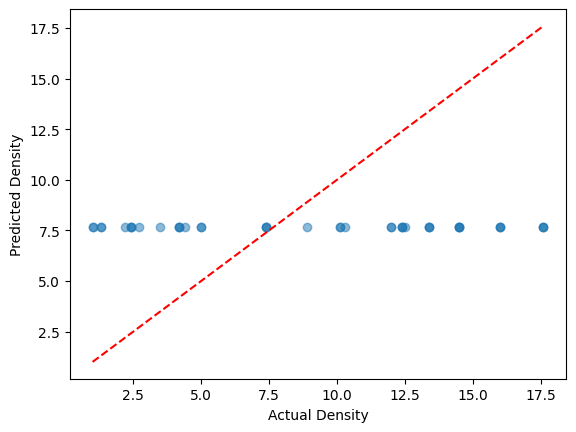

In [13]:
# 셀 15: 결과 시각화 (선택)
import matplotlib.pyplot as plt
plt.scatter(y_test,y_pred,alpha=0.5)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'r--')
plt.xlabel('Actual Density'); plt.ylabel('Predicted Density')
plt.show()